In [101]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import callback
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from optuna.integration import XGBoostPruningCallback

### Preprocessing

In [10]:
users_file = '../data/ml-1m/users.dat'
movies_file = '../data/ml-1m/movies.dat'
ratings_file = '../data/ml-1m/ratings.dat'

user_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
movie_cols = ['MovieID', 'Title', 'Genres']
rating_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']

users = pd.read_csv(users_file, sep='::', engine='python', names=user_cols)
movies = pd.read_csv(movies_file, sep='::', engine='python', names=movie_cols, encoding='latin-1')
ratings = pd.read_csv(ratings_file, sep='::', engine='python', names=rating_cols)

In [11]:
print("Users Data:")
print(users.head())
print("\nMovies Data:")
print(movies.head())
print("\nRatings Data:")
print(ratings.head())

Users Data:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

Movies Data:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Ratings Data:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


In [9]:
# print("Missing values in Users:", users.isnull().sum())
# print("Missing values in Movies:", movies.isnull().sum())
# print("Missing values in Ratings:", ratings.isnull().sum())

In [ ]:
# Feature Engineering: User Features

le_gender = LabelEncoder()
users['Gender'] = le_gender.fit_transform(users['Gender'])

le_occupation = LabelEncoder()
users['Occupation'] = le_occupation.fit_transform(users['Occupation'])

In [ ]:
# print(users.head())

In [ ]:
# Feature Engineering: Movie Features

genres = movies['Genres'].str.split('|', expand=True)
unique_genres = set()

# for col in genres.columns:
#     unique_genres.update(genres[col].unique())
# unique_genres = sorted(unique_genres)

for col in genres.columns:
    unique_genres.update(value for value in genres[col].unique() if value is not None)
unique_genres = sorted(unique_genres)

# for genre in unique_genres:
#     movies[f'Genre_{genre}'] = movies['Genres'].apply(lambda x: 1 if genre in x.split('|') else 0)

for genre in unique_genres:
    movies[f'Genre_{genre}'] = movies['Genres'].apply(lambda x: 1 if x and genre in x.split('|') else 0)

In [ ]:
# print(movies.head())

In [19]:
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return int(match.group(1))
    else:
        return None

movies['Release_Year'] = movies['Title'].apply(extract_year)
movies['Title'] = movies['Title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
movies['Release_Year'].fillna(movies['Release_Year'].median(), inplace=True)
movies.drop('Genres', axis=1, inplace=True)

In [ ]:
# print(movies.head())

In [ ]:
# print(ratings.head())

In [26]:
# Feature Engineering: Rating Features
ratings['Datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings['DayOfWeek'] = ratings['Datetime'].dt.dayofweek
ratings['Hour'] = ratings['Datetime'].dt.hour
ratings.drop('Timestamp', axis=1, inplace=True)
ratings.drop('Datetime', axis=1, inplace=True)

In [ ]:
# print(ratings.head())

In [28]:
# User Rating Average
user_avg_rating = ratings.groupby('UserID')['Rating'].mean().reset_index()
user_avg_rating.rename(columns={'Rating': 'User_Avg_Rating'}, inplace=True)
users = users.merge(user_avg_rating, on='UserID')

# Movie Rating Average
movie_avg_rating = ratings.groupby('MovieID')['Rating'].mean().reset_index()
movie_avg_rating.rename(columns={'Rating': 'Movie_Avg_Rating'}, inplace=True)
movies = movies.merge(movie_avg_rating, on='MovieID')

# User Rating Count
user_rating_count = ratings.groupby('UserID')['Rating'].count().reset_index()
user_rating_count.rename(columns={'Rating': 'User_Rating_Count'}, inplace=True)
users = users.merge(user_rating_count, on='UserID')

# Movie Rating Count
movie_rating_count = ratings.groupby('MovieID')['Rating'].count().reset_index()
movie_rating_count.rename(columns={'Rating': 'Movie_Rating_Count'}, inplace=True)
movies = movies.merge(movie_rating_count, on='MovieID')

In [32]:
# print(users.head())

In [33]:
# print(movies.head())

In [34]:
data = ratings.merge(users, on='UserID').merge(movies, on='MovieID')

In [36]:
# print(data.head())

In [37]:
user_features = ['Gender', 'Age', 'Occupation', 'User_Avg_Rating', 'User_Rating_Count']
movie_features = ['Release_Year', 'Movie_Avg_Rating', 'Movie_Rating_Count'] + [col for col in movies.columns if col.startswith('Genre_')]
interaction_features = ['DayOfWeek', 'Hour']
selected_features = user_features + movie_features + interaction_features

In [38]:
X = data[selected_features]
y = data['Rating']

In [41]:
data_sorted = data.sort_values(by='Release_Year')
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [86]:
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (700146, 28) (700146,)
Validation set: (150031, 28) (150031,)
Test set: (150032, 28) (150032,)


### Training

In [87]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    predictor='gpu_predictor',
    random_state=42,
    verbosity=1
)

In [88]:
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'predictor': 'gpu_predictor',
        'verbosity': 0,
        'random_state': 42,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'early_stopping_rounds': 50
    }

    model = xgb.XGBRegressor(**param)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

In [89]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

print("Number of Trials: ", len(study.trials))
print("Best Trial:")
trial = study.best_trial

print("  RMSE: ", trial.value)
print("  Best Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-12-26 23:14:28,492] A new study created in memory with name: no-name-45633ba7-39f0-4a3a-a102-c93f288dcbe7
[I 2024-12-26 23:14:43,196] Trial 0 finished with value: 0.8770223043478886 and parameters: {'learning_rate': 0.03574712922600244, 'n_estimators': 956, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.0017073967431528124, 'reg_alpha': 2.9154431891537547, 'reg_lambda': 0.2537815508265665}. Best is trial 0 with value: 0.8770223043478886.
[I 2024-12-26 23:14:46,549] Trial 1 finished with value: 0.8818205965263581 and parameters: {'learning_rate': 0.11114989443094977, 'n_estimators': 118, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.00541524411940254, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558}. Best is trial 0 with value: 0.8770223043478886.
[I 2024-12-26 23:14:51,245] Trial 2 finished with value: 0.8

Number of Trials:  100
Best Trial:
  RMSE:  0.8688036463582952
  Best Hyperparameters: 
    learning_rate: 0.04113364144837654
    n_estimators: 737
    max_depth: 10
    min_child_weight: 3
    subsample: 0.8872867293818927
    colsample_bytree: 0.9184881338127945
    gamma: 0.1059324979663342
    reg_alpha: 5.206448501673835
    reg_lambda: 0.011571026500045238


In [90]:
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

In [91]:
best_params = study.best_trial.params
best_params.update({
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor',
    'verbosity': 1,
    'random_state': 42,
    'early_stopping_rounds':50
})

In [92]:
model = xgb.XGBRegressor(**best_params)
model.fit(
    X_combined, y_combined,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:1.12233
[1]	validation_0-rmse:1.10553
[2]	validation_0-rmse:1.08991
[3]	validation_0-rmse:1.07532
[4]	validation_0-rmse:1.06167
[5]	validation_0-rmse:1.04894
[6]	validation_0-rmse:1.03710
[7]	validation_0-rmse:1.02881
[8]	validation_0-rmse:1.01835
[9]	validation_0-rmse:1.00872
[10]	validation_0-rmse:0.99963
[11]	validation_0-rmse:0.99116
[12]	validation_0-rmse:0.98337
[13]	validation_0-rmse:0.97808
[14]	validation_0-rmse:0.97111
[15]	validation_0-rmse:0.96462
[16]	validation_0-rmse:0.95858
[17]	validation_0-rmse:0.95299
[18]	validation_0-rmse:0.94930
[19]	validation_0-rmse:0.94438
[20]	validation_0-rmse:0.93980
[21]	validation_0-rmse:0.93657
[22]	validation_0-rmse:0.93250
[23]	validation_0-rmse:0.92882
[24]	validation_0-rmse:0.92527
[25]	validation_0-rmse:0.92219
[26]	validation_0-rmse:0.91914
[27]	validation_0-rmse:0.91701
[28]	validation_0-rmse:0.91434
[29]	validation_0-rmse:0.91179
[30]	validation_0-rmse:0.90946
[31]	validation_0-rmse:0.90721
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9184881338127945, device=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1059324979663342,
             gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04113364144837654,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=737, n_jobs=None,
             num_parallel_tree=None, ...)

In [97]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.8949
MAE: 0.7066


<Figure size 1200x800 with 0 Axes>

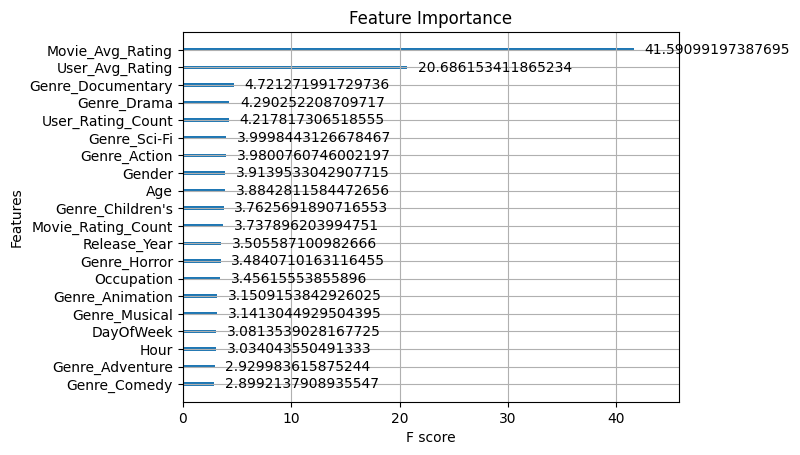

In [98]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Feature Importance')
plt.show()

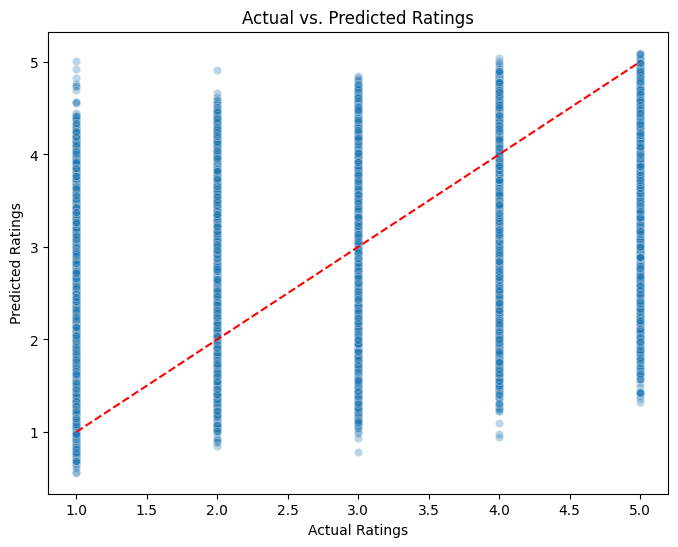

In [99]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

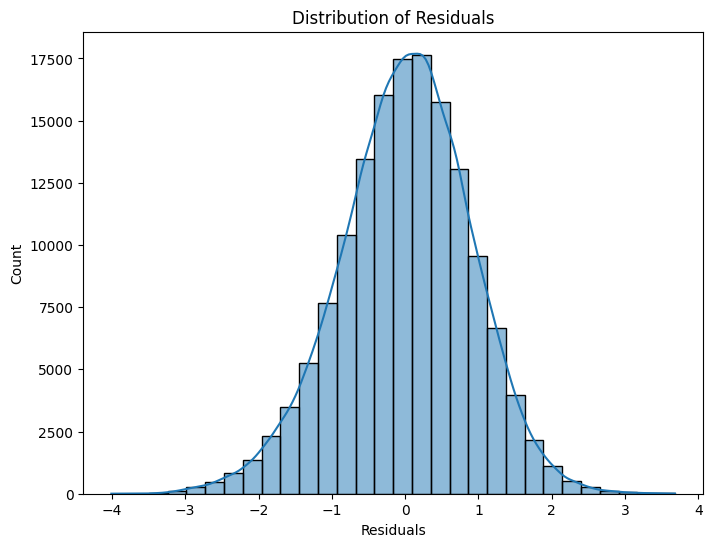

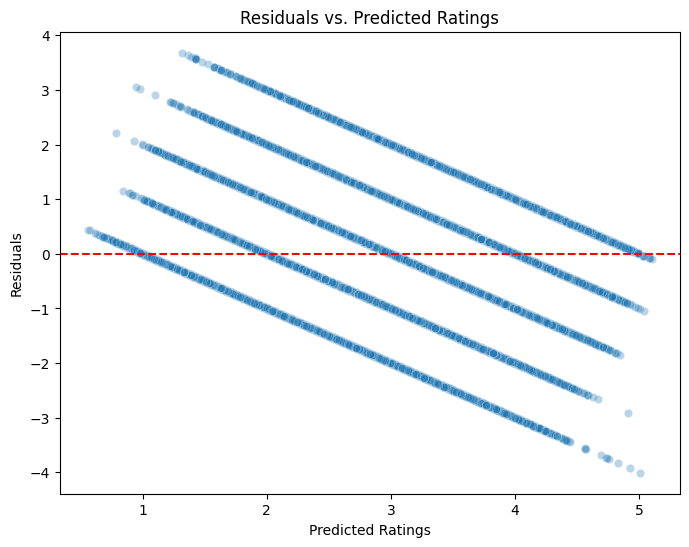

In [100]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Ratings')
plt.show()

### Inference

In [109]:
available_genres = unique_genres
global_avg_rating = y.mean()
global_avg_rating_count = users['User_Rating_Count'].mean()

In [143]:
print(movies.columns)

Index(['MovieID', 'Title', 'Genre_Action', 'Genre_Adventure',
       'Genre_Animation', 'Genre_Children's', 'Genre_Comedy', 'Genre_Crime',
       'Genre_Documentary', 'Genre_Drama', 'Genre_Fantasy', 'Genre_Film-Noir',
       'Genre_Horror', 'Genre_Musical', 'Genre_Mystery', 'Genre_Romance',
       'Genre_Sci-Fi', 'Genre_Thriller', 'Genre_War', 'Genre_Western',
       'Release_Year', 'Movie_Avg_Rating', 'Movie_Rating_Count'],
      dtype='object')


In [141]:
def recommend_movies_input(gender, age, occupation, preferred_genres, movies, users, ratings, model, N=10):
    gender_mapping = {'F': 0, 'M':1}
    occupation_mapping = {
        "other or not specified": 0,
        "academic/educator": 1,
        "artist": 2,
        "clerical/admin": 3,
        "college/grad student":4,
        "customer service":5,
        "doctor/health care":6,
        "executive/managerial":7,
        "farmer":8,
        "homemaker":9,
        "K-12 student":10,
        "lawyer":11,
        "programmer":12,
        "retired":13,
        "sales/marketing":14,
        "scientist":15,
        "self-employed":16,
        "technician/engineer":17,
        "tradesman/craftsman":18,
        "unemployed":19,
        "writer":20
    }
    age_mapping = {
        "Under 18":1,
        "18-24":18,
        "25-34":25,
        "35-44":35,
        "45-49":45,
        "50-55":50,
        "56+":56
    }

    if gender not in gender_mapping:
        raise ValueError()
    gender_encoded = gender_mapping[gender]

    if age not in age_mapping:
        raise ValueError()
    age_encoded = age_mapping[age]

    if occupation not in occupation_mapping:
        raise ValueError()
    occupation_encoded = occupation_mapping[occupation]

    overall_user_avg = users['User_Avg_Rating'].mean()
    overall_user_count = users['User_Rating_Count'].mean()

    user_features = {
        'Gender': gender_encoded,
        'Age': age_encoded,
        'Occupation': occupation_encoded,
        'User_Avg_Rating': overall_user_avg,
        'User_Rating_Count': overall_user_count
    }

    for genre in preferred_genres:
        if f'Genre_{genre}' not in movies.columns:
            raise ValueError(f"Genre '{genre}' not found in movie genres.")

    genre_cols = [f'Genre_{genre}' for genre in preferred_genres]
    filtered_movies = movies[movies[genre_cols].sum(axis=1) >=1 ]

    if filtered_movies.empty:
        raise ValueError("No movies found with the preferred genres.")

    user_df = pd.DataFrame([user_features] * len(filtered_movies))
    combined = pd.concat([user_df.reset_index(drop=True), filtered_movies.reset_index(drop=True)], axis=1)

    combined['DayOfWeek'] = 0
    combined['Hour'] = 0

    selected_features = ['Gender', 'Age', 'Occupation', 'User_Avg_Rating', 'User_Rating_Count',
                        'Release_Year', 'Movie_Avg_Rating', 'Movie_Rating_Count'] + \
                        [col for col in movies.columns if col.startswith('Genre_')] + ['DayOfWeek', 'Hour']

    X_user = combined[selected_features]
    preds = model.predict(X_user)
    combined['Predicted_Rating'] = preds
    top_n = combined.sort_values(by='Predicted_Rating', ascending=False).head(N)

    return top_n[['MovieID', 'Title', 'Predicted_Rating']]

In [147]:
user_gender = 'M'
user_age = '25-34'
user_occupation = 'college/grad student'
preferred_genres = ['Action', 'Comedy']

top_movies = recommend_movies_input(
    gender=user_gender,
    age=user_age,
    occupation=user_occupation,
    preferred_genres=preferred_genres,
    movies=movies,
    users=users,
    ratings=ratings,
    model=model,
    N=10
)

print(top_movies)

      MovieID                                              Title  \
1283     3233                                      Smashing Time   
354       858                                     Godfather, The   
778      2019  Seven Samurai (The Magnificent Seven) (Shichin...   
1169     2905                                            Sanjuro   
105       260                 Star Wars: Episode IV - A New Hope   
1450     3607                                  One Little Indian   
463      1198                            Raiders of the Lost Ark   
317       745                                     Close Shave, A   
446      1148                                Wrong Trousers, The   
707      1830                                   Follow the Bitch   

      Predicted_Rating  
1283          4.498532  
354           4.496045  
778           4.466944  
1169          4.462358  
105           4.457338  
1450          4.452814  
463           4.415864  
317           4.408375  
446           4.366920  
7